**Processing Sequences Using RNNs and CNNs**

This notebook is inspired from the handson-ml2 GitHub repository by Aurélien Geron

https://github.com/ageron/handson-ml2

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [96]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Basic RNNs

### Generate the Dataset

For simplicity, we are using a time series generated by the `generate_time_series` function, shown here:

In [97]:
# This function creates as many time series as requested (via the batch_size argument),
# each of length n_steps, and there is just one value per time step in each series
# (i.e., all series are univariate)
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    # The linspace() function returns evenly spaced numbers over a specified interval
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    
    # The function returns a NumPy array of shape [batch size, time steps, 1],
    # where each series is the sum of two sine waves of fixed amplitudes but
    # random frequencies and phases, plus a bit of noise
    return series[..., np.newaxis].astype(np.float32)

Now let’s create a training set, a validation set, and a test set using this function:

In [98]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [99]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

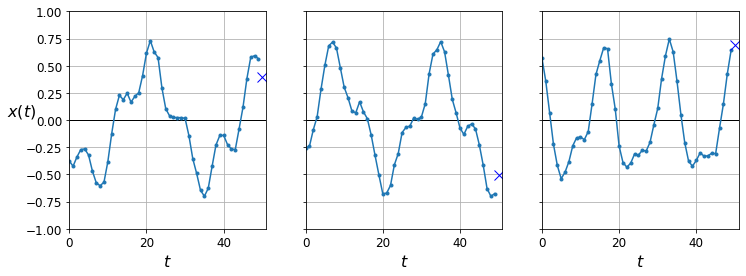

In [100]:
# Plotting the data created above
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    # hlines() plot horizontal lines at each y from xmin to xmax
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    # sca() sets the current axes to ax
    # and the current figure to the parent of ax
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
    
plt.show()

In [101]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

### Computing Baselines

Now let’s create a Baseline Metrics or else we may end up thinking our model works great when in fact it is doing worse than basic models. The simplest approach is to predict the last value in each series. This is called naive forecasting, and it is sometimes surprisingly difficult to outperform.

In [102]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

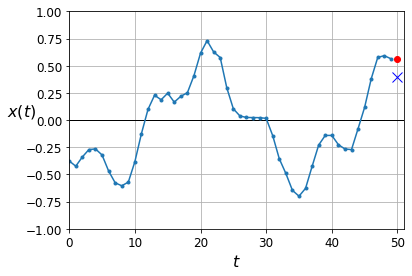

In [103]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a `Flatten` layer. Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

# Baseline metrics
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

***The following code has been intentionally commented because it is highly process intensive, and takes too long to execute completely.***

We are loading a saved version of the same model instead, and working on that. A similar process has been followed throughout the rest of the notebook to make it easy to follow during the lecture without losing continuity. Please feel free to uncomment the same and try it on your own.

In [105]:
# history = model.fit(X_train, y_train, epochs=20,
#                     validation_data=(X_valid, y_valid))
# np.save('history/linear_predictions.npy', history.history)
# model.save("models/linear_predictions.h5")

In [106]:
# Loading saved model
model = keras.models.load_model('models/linear_predictions.h5')

# Loading saved history
history = np.load('history/linear_predictions.npy',allow_pickle='TRUE').item()

In [107]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 59us/sample - loss: 0.0041


0.004145486038178206

That’s much better than the naive approach!

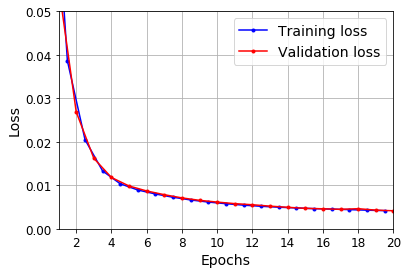

In [108]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

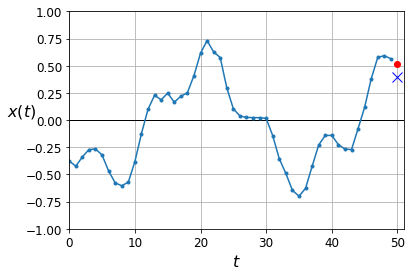

In [109]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

Let’s see if we can beat the linear model with a simple RNN:

In [110]:
# This is really the simplest RNN you can build.
# It just contains a single layer, with a single neuron.
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [111]:
# history = model.fit(X_train, y_train, epochs=20,
#                     validation_data=(X_valid, y_valid))
# np.save('history/simple_rnn.npy', history.history)
# model.save("models/simple_rnn.h5")

In [112]:
model = keras.models.load_model('models/simple_rnn.h5')
history = np.load('history/simple_rnn.npy',allow_pickle='TRUE').item()

In [113]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 241us/sample - loss: 0.0109


0.010885455444455147

The MSE for this simple RNN model reaches only 0.014, so it is better than the naive approach but it does not beat the simple linear model.

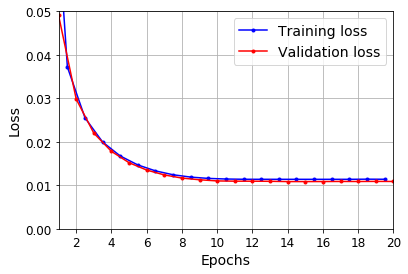

In [114]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

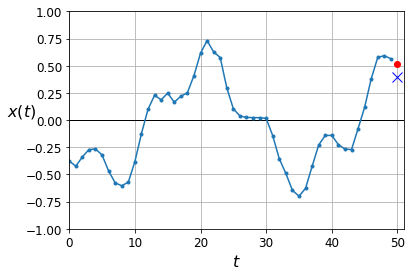

In [115]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Go Back to the Slides**

# Deep RNNs

Implementing a deep RNN with `tf.keras` is quite simple: just stack recurrent layers. In this example, we use three `SimpleRNN` layers (but we could add any other type of recurrent layer, such as an `LSTM` layer or a `GRU` layer:

In [116]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")

In [117]:
# history = model.fit(X_train, y_train, epochs=20,
#                     validation_data=(X_valid, y_valid))
# np.save('history/deep_rnns.npy', history.history)
# model.save("models/deep_rnns.h5")

In [118]:
model = keras.models.load_model('models/deep_rnns.h5')
history = np.load('history/deep_rnns.npy',allow_pickle='TRUE').item()

In [119]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 2s 988us/sample - loss: 0.0029


0.0029341070633381607

We finally managed to beat the linear model!

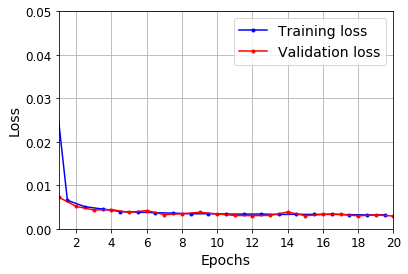

In [120]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

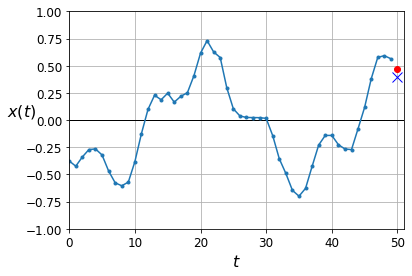

In [121]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Go Back to the Slides**

Create the second `SimpleRNN` layer return only the last output:

In [122]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    # Remove return_sequences=True from the second (now last) recurrent layer
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

In [123]:
# history = model.fit(X_train, y_train, epochs=20,
#                     validation_data=(X_valid, y_valid))
# np.save('history/second_simple.npy', history.history)
# model.save("models/second_simple_rnn.h5")

In [124]:
model = keras.models.load_model('models/second_simple_rnn.h5')
history = np.load('history/second_simple.npy',allow_pickle='TRUE').item()

In [125]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 480us/sample - loss: 0.0026


0.002576804503798485

This model converges faster and performs just as well. Plus, you could change the output activation function if you wanted.

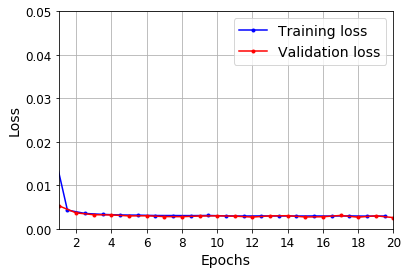

In [126]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

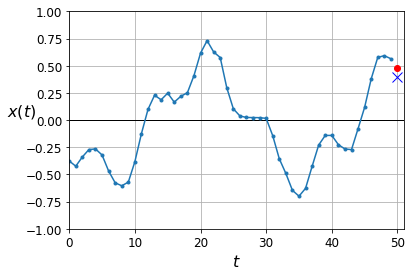

In [127]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

**Go Back to the Slides**

# Forecasting Several Steps Ahead

## Option 1

Here we are using the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on.

In [128]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [129]:
Y_pred.shape

(1, 10, 1)

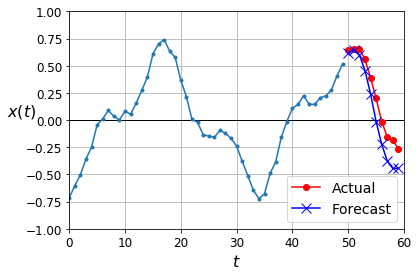

In [130]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Go Back to the Slides**

## Option 2

We first need to regenerate the sequences with 9 more time steps.

In [131]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [132]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [133]:
Y_pred.shape

(2000, 10)

In [134]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.02727729

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [135]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [136]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")

In [137]:
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))
# np.save('history/forecasting_several_steps_i.npy', history.history)
# model.save("models/forecasting_several_steps_i.h5")

In [138]:
model = keras.models.load_model('models/forecasting_several_steps_i.h5')
history = np.load('history/forecasting_several_steps_i.npy',allow_pickle='TRUE').item()

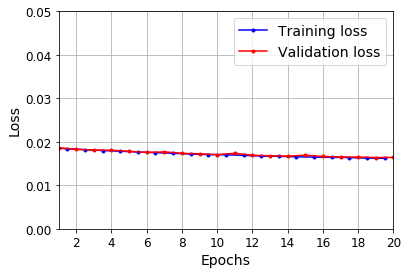

In [139]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [140]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    # Here we need to output layer to have 10 units instead of 1
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")

In [141]:
# history = model.fit(X_train, Y_train, epochs=20,
#                     validation_data=(X_valid, Y_valid))
# np.save('history/forecasting_several_steps_ii.npy', history.history)
# model.save("models/forecasting_several_steps_ii.h5")

In [142]:
model = keras.models.load_model('models/forecasting_several_steps_ii.h5')
history = np.load('history/forecasting_several_steps_ii.npy',allow_pickle='TRUE').item()

In [143]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

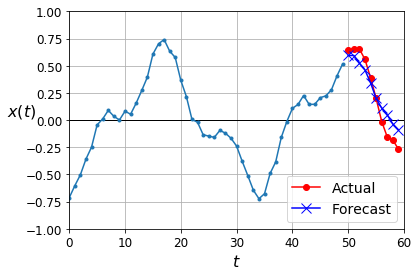

In [144]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

This model works nicely, and is much better than the linear model!

**Go Back to the Slides**

## Option 3

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [145]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [146]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

To turn the model into a **sequence-to-sequence** model, we must set `return_sequences=True` in all recurrent layers (even the last one), and we must apply the output `Dense` layer at every time step. Keras offers a `TimeDistributed` layer for this very purpose: It wraps any layer (e.g., a `Dense` layer) and applies it at every time step of its input sequence.

In [147]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

# All outputs are needed during training, but only the output at the last time step is
# useful for predictions and for evaluation. So although we will rely on the MSE over all
# the outputs for training, we will use a custom metric for evaluation, to only compute
# the MSE over the output at the last time step:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])

In [148]:
#history = model.fit(X_train, Y_train, epochs=20,
#                    validation_data=(X_valid, Y_valid))
#np.save('history/forecasting_several_steps_iii.npy', history.history)
#model.save("models/forecasting_several_steps_iii.h5")

In [149]:
dependencies = {'last_time_step_mse': last_time_step_mse}
model = keras.models.load_model('models/forecasting_several_steps_iii.h5', custom_objects=dependencies)
history = np.load('history/forecasting_several_steps_iii.npy',allow_pickle='TRUE').item()

In [150]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

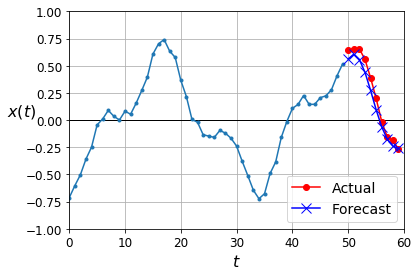

In [151]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [152]:
np.mean(keras.metrics.mean_squared_error(Y_new, Y_pred))

0.006321259

This is 25% better than the previous model.

**Go Back to the Slides**

# Handling Long Sequences

## Fighting the Unstable Gradients Problem

### Deep RNN with Batch Norm

Adding a `BatchNormalization` layer before each recurrent layer:

In [153]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [154]:
#history = model.fit(X_train, Y_train, epochs=20,
#                    validation_data=(X_valid, Y_valid))
#np.save('history/deep_rnn_batch_norm.npy', history.history)
#model.save("models/deep_rnn_batch_norm.h5")

In [155]:
dependencies = {'last_time_step_mse': last_time_step_mse}
model = keras.models.load_model('models/deep_rnn_batch_norm.h5', custom_objects=dependencies)
history = np.load('history/deep_rnn_batch_norm.npy',allow_pickle='TRUE').item()

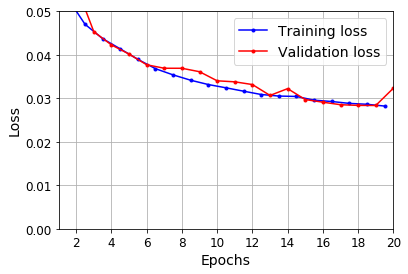

In [156]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

**Go Back to the Slides**

### Deep RNNs with Layer Norm

In [157]:
# Generating time series data
# This function creates as many time series as requested
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [158]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [159]:
from tensorflow.keras.layers import LayerNormalization

Here we are implementing a custom memory cell which will behave like a `SimpleRNNCell`,except it will also apply Layer Normalization at each time step. The `call` method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice. Next, the `call` method applies `LayerNormalization`, followed by the activation function. Finally, it returns the outputs twice (once as the outputs, and once as the new hidden states)

In [160]:

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    # call() method takes two arguments:
    # the inputs at the current time step and
    # the hidden states from the previous time step
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

To use this custom cell, all we need to do is create a `keras.layers.RNN` layer, passing it a cell instance:

In [161]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=1,
                    validation_data=(X_valid, Y_valid))
#history = model.fit(X_train, Y_train, epochs=20,
#                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
7000/7000 [==============================] - 24s 3ms/sample - loss: 0.1602 - last_time_step_mse: 0.1559 - val_loss: 0.0731 - val_last_time_step_mse: 0.0679


**Go Back to the Slides**

## Tackling the Short-Term Memory Problem

### LSTMs

In Keras, you can simply use the `LSTM` layer instead of the `SimpleRNN` layer:

In [162]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [163]:
#history = model.fit(X_train, Y_train, epochs=20,
#                    validation_data=(X_valid, Y_valid))
#np.save('history/lstm.npy', history.history)
#model.save("models/lstm.h5")

In [164]:
dependencies = {'last_time_step_mse': last_time_step_mse}
model = keras.models.load_model('models/lstm.h5', custom_objects=dependencies)
history = np.load('history/lstm.npy',allow_pickle='TRUE').item()

In [165]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 1s 742us/sample - loss: 0.0240 - last_time_step_mse: 0.0086


[0.024016656413674356, 0.008551416]

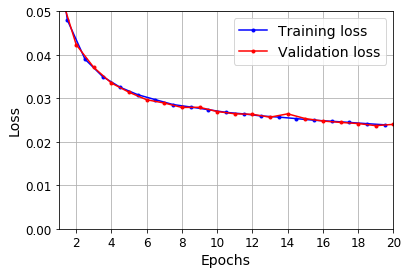

In [166]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

In [167]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

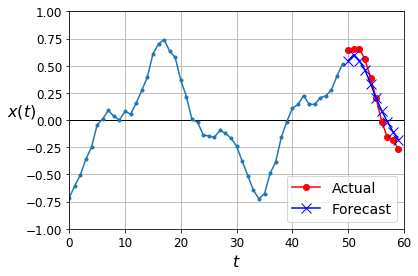

In [168]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Go Back to the Slides**

### GRUs

In [169]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [170]:
#history = model.fit(X_train, Y_train, epochs=20,
#                    validation_data=(X_valid, Y_valid))
#np.save('history/gru.npy', history.history)
#model.save("models/gru.h5")

In [171]:
dependencies = {'last_time_step_mse': last_time_step_mse}
model = keras.models.load_model('models/gru.h5', custom_objects=dependencies)
history = np.load('history/gru.npy',allow_pickle='TRUE').item()

In [172]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 1s 659us/sample - loss: 0.0241 - last_time_step_mse: 0.0103


[0.024071002453565596, 0.01029832]

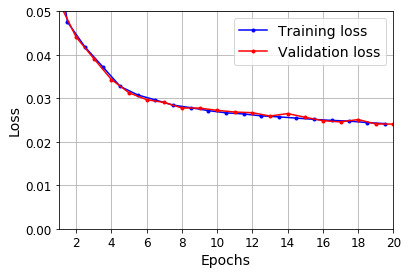

In [173]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

In [174]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

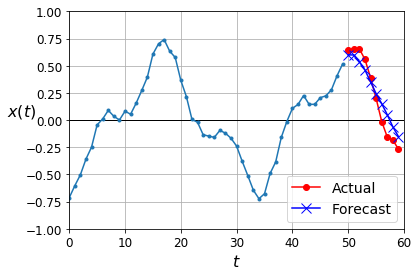

In [175]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Go Back to the Slides**

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

The following model starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details.

In [176]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    # A 1D convolutional layer with a stride of 1 and "same" padding will have an
    # output sequence will have the same length as the input sequence
    # But if you use "valid" padding or a stride greater than 1, then
    # the output sequence will be shorter than the input sequence
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

By shortening the sequences, the convolutional layer may help the `GRU` layers detect longer patterns. Also, we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2.

In [177]:
#history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
#                    validation_data=(X_valid, Y_valid[:, 3::2]))
#np.save('history/1d_conv_layer.npy', history.history)
#model.save("models/1d_conv_layer.h5")

In [178]:
dependencies = {'last_time_step_mse': last_time_step_mse}
model = keras.models.load_model('models/1d_conv_layer.h5', custom_objects=dependencies)
history = np.load('history/1d_conv_layer.npy',allow_pickle='TRUE').item()

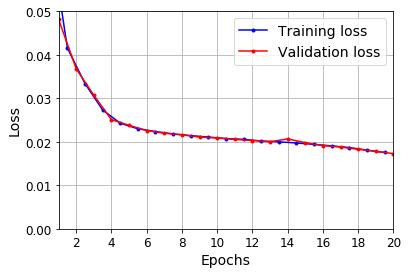

In [179]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

**Go Back to the Slides**

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

Here is a Keras implementation of the WaveNet architecture as shown in the WaveNet paper where the authors stacked 10 convolutional layers with dilation rates of 1, 2, 4, 8, …, 256, 512, then they stacked another group of 10 identical layers (also with dilation rates 1, 2, 4, 8, …, 256, 512), then again another identical group of 10 layers. They also left-padded the input sequences with a number of zeros equal to the dilation rate before every layer, to preserve the same sequence length throughout the network.

In [180]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
# Adding similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
# Output layer: a convolutional layer with 10 filters of size 1 and without any activation function
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [181]:
#history = model.fit(X_train, Y_train, epochs=20,
#                    validation_data=(X_valid, Y_valid))
#np.save('history/wavenet.npy', history.history)
#model.save("models/wavenet.h5")

In [182]:
dependencies = {'last_time_step_mse': last_time_step_mse}
model = keras.models.load_model('models/wavenet.h5', custom_objects=dependencies)
history = np.load('history/wavenet.npy',allow_pickle='TRUE').item()

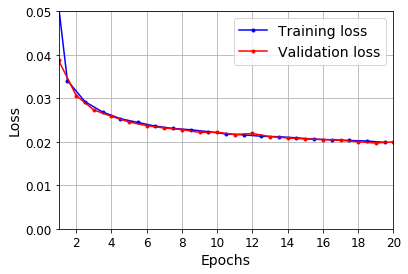

In [183]:
plot_learning_curves(history["loss"], history["val_loss"])
plt.show()

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of `ReLU` and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [184]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [185]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [186]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [187]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [188]:
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 6s 833us/sample - loss: 0.1299 - last_time_step_mse: 0.1258 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
7000/7000 [==============================] - 4s 521us/sample - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1218 - val_last_time_step_mse: 0.1190
